* eruptions  numeric  Eruption time in mins
* waiting    numeric  Waiting time to next eruption

sources: https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat

In [13]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
data = 'https://gist.githubusercontent.com/JoeGanser/a95811af937f413f3237e9b5b4c24e78/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv'
data = pd.read_csv(data,sep='\t')
data.head()

2023-04-24 21:33:44,272 [10933] INFO     numexpr.utils: Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-04-24 21:33:44,272 [10933] INFO     numexpr.utils: NumExpr defaulting to 8 threads.


,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


Using visualization techniques, we can observe how the data is distributed. This will suggest the number of clusters we can use to describe the data.

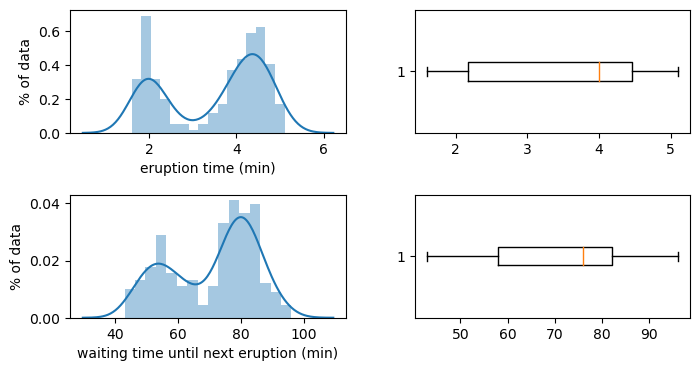

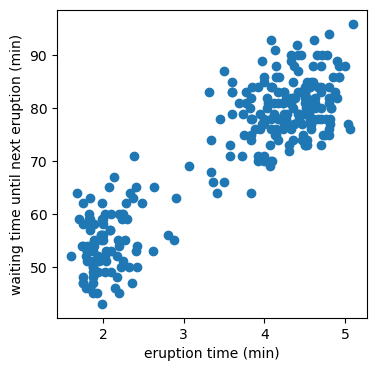

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
n = 4
plt.figure(figsize=(2*n,n))
plt.subplot(2,2,1)
col = 'eruptions'
sns.distplot(data[col],bins=int(np.sqrt(data[col].shape[0])))
plt.ylabel('% of data')
plt.xlabel('eruption time (min)')
plt.subplot(2,2,2)
plt.boxplot(data[col],vert=False)
####
plt.subplot(2,2,3)
col = 'waiting'
sns.distplot(data[col],bins=int(np.sqrt(data[col].shape[0])))
plt.ylabel('% of data')
plt.xlabel('waiting time until next eruption (min)')
plt.subplot(2,2,4)
plt.boxplot(data[col],vert=False)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.25)


plt.figure(figsize=(n,n))
plt.scatter(data['eruptions'],data['waiting'])
plt.xlabel('eruption time (min)')
plt.ylabel('waiting time until next eruption (min)')
plt.show()

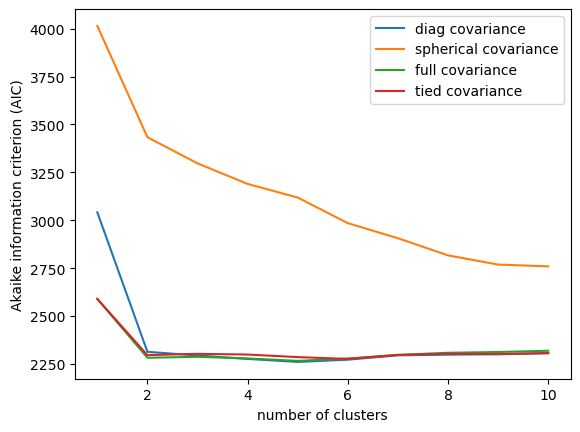

In [15]:
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
n_components = range(1,11)
covariances = ['diag','spherical','full','tied']
models = {c:[] for c in covariances}
for cov in covariances:
    for n in n_components:
        models[cov].append(GMM(n,covariance_type=cov,random_state=0).fit(data))

for cov in covariances:
    plt.plot(n_components, [m.aic(data) for m in models[cov]], label='{} covariance'.format(cov))

plt.legend(loc='best')
plt.ylabel('Akaike information criterion (AIC)')
plt.xlabel('number of clusters')
plt.show()

### Find now that we've found the optimal number of components, plot them

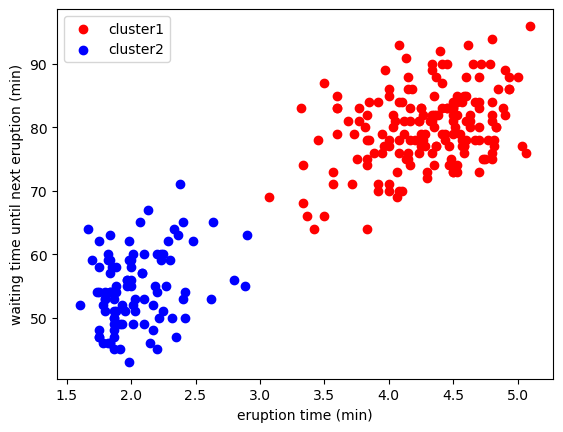

In [16]:
preds = GMM(n_components=2,covariance_type='full').fit(data).predict(data)
preds = ['red' if i==0 else 'blue' for i in preds]
data['cluster'] = pd.Series(preds)
cluster_colors = {'red':'cluster1','blue':'cluster2'}
for color in cluster_colors.keys():
    _ = data[data[data.columns[-1]]==color]
    plt.scatter(_['eruptions'],_['waiting'],c=color,label=cluster_colors[color])
data.drop('cluster',axis=1,inplace=True)
plt.legend()
plt.xlabel('eruption time (min)')
plt.ylabel('waiting time until next eruption (min)')
plt.show()

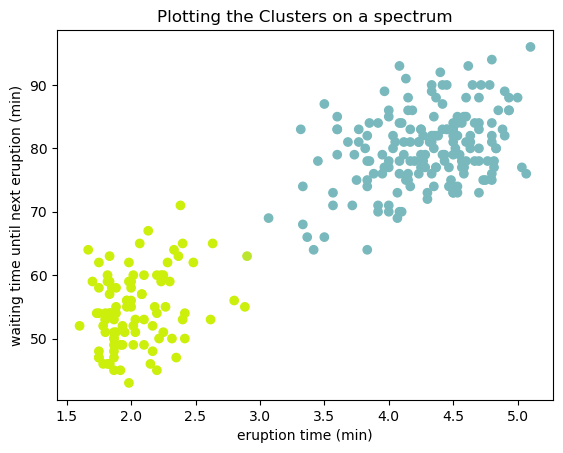

In [18]:
pred_proba = GMM(n_components=2,covariance_type='full').fit(data).predict_proba(data)
# Generate two random colors
color1 = np.random.rand(3)
color2 = np.random.rand(3)
# Create an array of weights that determine the mixture of the two colors
weights = pred_proba[:,0]
# Create an array of RGB color tuples that represent the mixture of the two colors
colors = np.array([(1 - weight) * color1 + weight * color2 for weight in weights])
# Create the scatter plot with the mixed colors
plt.scatter(data['eruptions'],data['waiting'], c=colors)
# Show the plot
plt.title("Plotting the Clusters on a spectrum")
plt.xlabel('eruption time (min)')
plt.ylabel('waiting time until next eruption (min)')
plt.show()

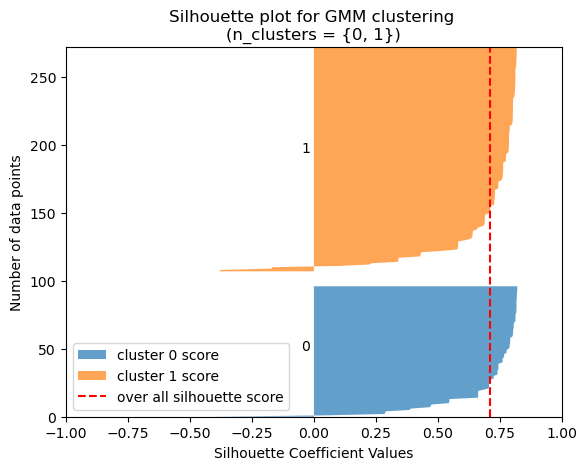

In [26]:
from sklearn.metrics import silhouette_samples, silhouette_score

N_clus = 2
labels = preds = GMM(n_components=N_clus,covariance_type='full').fit(data).predict(data)
silhouette_scores = silhouette_samples(data, labels)

# Get the silhouette score for the entire dataset
overall_silhouette_score = silhouette_score(data, labels)

# Plot the silhouette scores for each cluster
fig, ax = plt.subplots()
ax.set_xlim([-1, 1])
ax.set_ylim([0, len(data)])

y_lower = 0
for i in range(N_clus):
    cluster_silhouette_scores = silhouette_scores[labels == i]
    cluster_silhouette_scores.sort()
    size_cluster_i = cluster_silhouette_scores.shape[0]
    y_upper = y_lower + size_cluster_i
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores,
                      alpha=0.7, edgecolor='none',label='cluster {} score'.format(i))
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title("Silhouette plot for GMM clustering \n(n_clusters = {})".format(set(labels)))
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Number of data points")

ax.axvline(x=overall_silhouette_score, color="red", linestyle="--",label='over all silhouette score')
plt.legend(loc='lower left')
plt.show()

# Sources

1. https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat
2. https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
3. https://en.wikipedia.org/wiki/Akaike_information_criterion
4. https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py